In [25]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("spam.csv", encoding="latin-1")
df = df[["v1", "v2"]]
df.columns = ["label", "message"]
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [26]:
class_counts = df["label"].value_counts()

summary_table = pd.DataFrame({
    "Count": class_counts,
    "Percentage (%)": (class_counts / class_counts.sum() * 100).round(2)
})

summary_table

,Count,Percentage (%)
label,,
ham,4825,86.59
spam,747,13.41


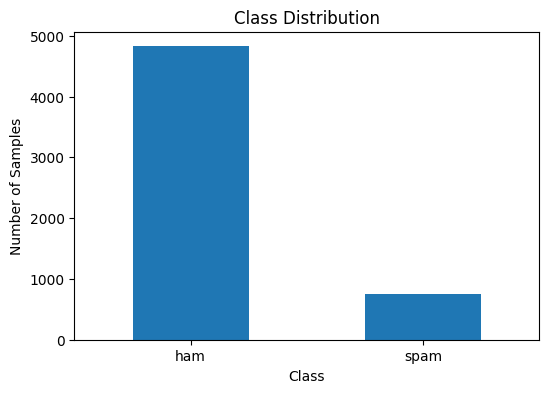

In [27]:
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()

The dataset is clearly imbalanced. The number of ham messages is significantly higher than spam messages. This class imbalance can bias the classifier toward the majority class, resulting in misleading accuracy before applying any data balancing techniques.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df["message"]).toarray()

df["features"] = list(X)
df[["label", "features"]].head()

,label,features
0,ham,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,ham,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,spam,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,ham,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,ham,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [29]:
# Step 2: GAN Implementation
import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

X_spam = torch.tensor(
    df[df["label"] == "spam"]["features"].tolist(),
    dtype=torch.float32
)


input_dim = X_spam.shape[1]
noise_dim = 100
batch_size = 64
epochs = 100

Each SMS message was converted into a numerical representation using TF-IDF. Due to the short length of SMS messages, the resulting feature vectors are sparse, containing many zero values. This is expected behavior and reflects the absence of most vocabulary terms in a given message. The number of features was limited to 1000 to reduce dimensionality and simplify GAN training.

In [30]:
# Vanilla GAN
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.net(z)

In [31]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [32]:
#Training Vanilla GAN (Spam only)
G_vanilla = Generator(noise_dim, input_dim).to(device)
D = Discriminator(input_dim).to(device)

criterion = nn.BCELoss()
opt_G = optim.Adam(G_vanilla.parameters(), lr=0.0002)
opt_D = optim.Adam(D.parameters(), lr=0.0002)

for epoch in range(epochs):
    idx = torch.randint(0, X_spam.size(0), (batch_size,))
    real = X_spam[idx]

    z = torch.randn(batch_size, noise_dim).to(device)
    fake = G_vanilla(z)

    loss_D = criterion(D(real), torch.ones(batch_size,1).to(device)) + \
             criterion(D(fake.detach()), torch.zeros(batch_size,1).to(device))

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    loss_G = criterion(D(fake), torch.ones(batch_size,1).to(device))

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

In [33]:
# WGAN
# critic
class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

In [34]:
#Training WGAN (Spam only)
G_wgan = Generator(noise_dim, input_dim).to(device)
C = Critic(input_dim).to(device)

opt_G = optim.RMSprop(G_wgan.parameters(), lr=0.00005)
opt_C = optim.RMSprop(C.parameters(), lr=0.00005)
clip_value = 0.01

for epoch in range(epochs):
    for _ in range(5):
        idx = torch.randint(0, X_spam.size(0), (batch_size,))
        real = X_spam[idx]

        z = torch.randn(batch_size, noise_dim).to(device)
        fake = G_wgan(z)

        loss_C = -(torch.mean(C(real)) - torch.mean(C(fake)))

        opt_C.zero_grad()
        loss_C.backward()
        opt_C.step()

        for p in C.parameters():
            p.data.clamp_(-clip_value, clip_value)

    z = torch.randn(batch_size, noise_dim).to(device)
    fake = G_wgan(z)

    loss_G = -torch.mean(C(fake))

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

In [35]:
# CGAN
# Conditional Generator
class CGAN_Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z, y):
        return self.net(torch.cat([z, y], dim=1))

In [36]:
# Conditional Discriminator
class CGAN_Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

In [37]:
# Training CGAN (Spam only)
label_dim = 1
G_cgan = CGAN_Generator(noise_dim, label_dim, input_dim).to(device)
D_cgan = CGAN_Discriminator(input_dim, label_dim).to(device)

opt_G = optim.Adam(G_cgan.parameters(), lr=0.0002)
opt_D = optim.Adam(D_cgan.parameters(), lr=0.0002)
criterion = nn.BCELoss()

for epoch in range(epochs):
    idx = torch.randint(0, X_spam.size(0), (batch_size,))
    real = X_spam[idx]
    labels = torch.ones(batch_size, label_dim).to(device)

    z = torch.randn(batch_size, noise_dim).to(device)
    fake = G_cgan(z, labels)

    loss_D = criterion(D_cgan(real, labels), torch.ones(batch_size,1).to(device)) + \
             criterion(D_cgan(fake.detach(), labels), torch.zeros(batch_size,1).to(device))

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    loss_G = criterion(D_cgan(fake, labels), torch.ones(batch_size,1).to(device))

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

In this step, Generative Adversarial Networks (GANs) were implemented to generate synthetic samples for the minority class (Spam). First, a Vanilla GAN was implemented from scratch using a simple fully connected architecture. The generator learns to produce synthetic TF-IDF feature vectors, while the discriminator distinguishes between real and generated samples. The Vanilla GAN was trained exclusively on the minority class to capture its underlying data distribution.

In addition to the Vanilla GAN, two GAN variants were implemented and trained on the minority class only. The first variant was the Wasserstein GAN (WGAN), which replaces the standard discriminator with a critic and uses the Wasserstein distance to improve training stability. The second variant was a Conditional GAN (CGAN), where class information was incorporated as a conditioning input to guide the data generation process. Since the training focused on a single minority class, a fixed class condition was used.

All GAN models were trained solely on Spam samples to generate new synthetic feature vectors representing the minority class. These generated samples were later used to balance the dataset and evaluate the impact of different GAN architectures on classification performance.

In [41]:
# Generate synthetic Spam samples using Vanilla GAN
z = torch.randn(1000, noise_dim).to(device)
synthetic_spam_vanilla = G_vanilla(z).detach().cpu()

In [43]:
# Generate synthetic Spam samples using GAN Variant
z = torch.randn(1000, noise_dim).to(device)
synthetic_spam_wgan = G_wgan(z).detach().cpu()   # أو G_cgan

The synthetic samples were generated by the trained GAN models and stored as tensors. These tensors were later converted to NumPy arrays and used to balance the training dataset.

In [38]:
# Step 3: Data Augmentation & Classification
# I will use MLP (scikit-learn) because Suitable for TF-IDF
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Converting features to numpy
X = np.vstack(df["features"].values)
y = df["label"].map({"ham": 0, "spam": 1}).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [39]:
# Training the classifier on the original data (without balancing)
clf_original = MLPClassifier(hidden_layer_sizes=(128,), max_iter=20, random_state=42)
clf_original.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128,), max_iter=20, random_state=42)

In [42]:
# Data balancing using Vanilla GAN
with torch.no_grad():
    z = torch.randn(batch_size, noise_dim).to(device)
    synthetic_spam_vanilla = G_vanilla(z)
X_spam_gan = synthetic_spam_vanilla.numpy()
y_spam_gan = np.ones(len(X_spam_gan))

X_bal_vanilla = np.vstack([X_train, X_spam_gan])
y_bal_vanilla = np.hstack([y_train, y_spam_gan])

clf_vanilla = MLPClassifier(hidden_layer_sizes=(128,), max_iter=20, random_state=42)
clf_vanilla.fit(X_bal_vanilla, y_bal_vanilla)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128,), max_iter=20, random_state=42)

In [44]:
# Data balancing using a GAN variant (WGAN)
X_spam_gan_var = synthetic_spam_wgan.numpy()  #synthetic_spam_cgan
y_spam_gan_var = np.ones(len(X_spam_gan_var))

X_bal_variant = np.vstack([X_train, X_spam_gan_var])
y_bal_variant = np.hstack([y_train, y_spam_gan_var])

clf_variant = MLPClassifier(hidden_layer_sizes=(128,), max_iter=20, random_state=42)
clf_variant.fit(X_bal_variant, y_bal_variant)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128,), max_iter=20, random_state=42)

In this step, the synthetic data generated by the GAN models was used to balance the original imbalanced dataset. The generated minority class samples were combined with the original training data to create balanced datasets. Three training scenarios were considered to evaluate the effect of data augmentation.

First, a classification model was trained on the original imbalanced dataset to establish a baseline performance. Second, the same classifier was trained on a dataset balanced using synthetic samples generated by the Vanilla GAN. Third, the classifier was trained on a dataset balanced using synthetic samples generated by the selected GAN variant.

In all scenarios, the same classification architecture and training settings were used to ensure a fair comparison. This step enabled a direct evaluation of the impact of GAN-based data augmentation on classification performance.

In [45]:
# Step 4 Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

In [46]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_prob),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

In [47]:
# Evaluate All Scenarios
results_original = evaluate_model(clf_original, X_test, y_test)
results_vanilla  = evaluate_model(clf_vanilla, X_test, y_test)
results_variant  = evaluate_model(clf_variant, X_test, y_test)

In [48]:
# Summary Table (Metrics)
results_table = pd.DataFrame([
    {
        "Model": "Original (Imbalanced)",
        "Accuracy": results_original["Accuracy"],
        "Precision": results_original["Precision"],
        "Recall": results_original["Recall"],
        "F1-Score": results_original["F1-Score"],
        "AUC-ROC": results_original["AUC-ROC"]
    },
    {
        "Model": "Vanilla GAN Balanced",
        "Accuracy": results_vanilla["Accuracy"],
        "Precision": results_vanilla["Precision"],
        "Recall": results_vanilla["Recall"],
        "F1-Score": results_vanilla["F1-Score"],
        "AUC-ROC": results_vanilla["AUC-ROC"]
    },
    {
        "Model": "GAN Variant Balanced",
        "Accuracy": results_variant["Accuracy"],
        "Precision": results_variant["Precision"],
        "Recall": results_variant["Recall"],
        "F1-Score": results_variant["F1-Score"],
        "AUC-ROC": results_variant["AUC-ROC"]
    }
])

results_table

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Original (Imbalanced),0.983857,0.978102,0.899329,0.937063,0.979914
1,Vanilla GAN Balanced,0.984753,0.978261,0.906040,0.940767,0.980602
2,GAN Variant Balanced,0.983857,0.978102,0.899329,0.937063,0.980303


In [49]:
# Confusion Matrices
print("Original Dataset")
print(results_original["Confusion Matrix"])

print("\nVanilla GAN Balanced")
print(results_vanilla["Confusion Matrix"])

print("\nGAN Variant Balanced")
print(results_variant["Confusion Matrix"])

Original Dataset
[[963   3]
 [ 15 134]]

Vanilla GAN Balanced
[[963   3]
 [ 14 135]]

GAN Variant Balanced
[[963   3]
 [ 15 134]]


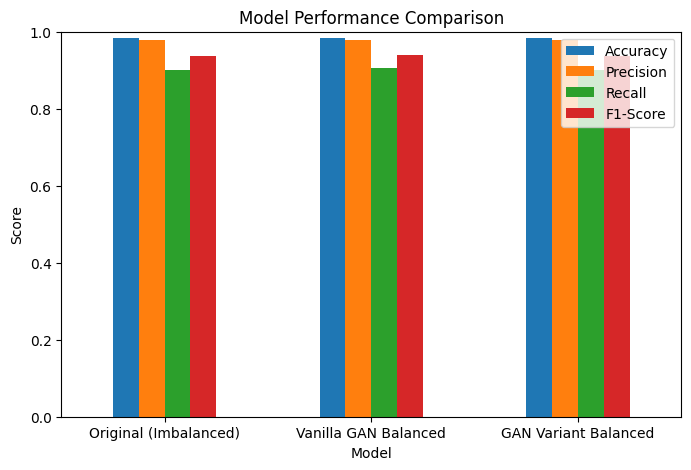

In [50]:
# Metrics Comparison Plot
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

results_table.set_index("Model")[metrics].plot(
    kind="bar",
    figsize=(8,5)
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()


In [51]:
# Visualization of Generated Samples
print("Sample Synthetic Spam (Vanilla GAN):")
print(synthetic_spam_vanilla[:2])
print("\nSample Synthetic Spam (GAN Variant):")
print(synthetic_spam_wgan[:2])

Sample Synthetic Spam (Vanilla GAN):
tensor([[ 0.0286,  0.2464,  0.1652,  ..., -0.4257, -0.4140, -0.1157],
        [ 0.2090,  0.1948, -0.1810,  ..., -0.1434, -0.0864, -0.0969]])

Sample Synthetic Spam (GAN Variant):
tensor([[ 0.1397, -0.1109, -0.0970,  ..., -0.3429,  0.2489, -0.2969],
        [ 0.1380, -0.1778, -0.0271,  ..., -0.2134,  0.0345,  0.1350]])


In this step, the performance of the classification model was evaluated across all three training scenarios: the original imbalanced dataset, the dataset balanced using synthetic samples generated by the Vanilla GAN, and the dataset balanced using synthetic samples generated by the selected GAN variant. The same test set was used in all cases to ensure a fair and consistent comparison.

Multiple evaluation metrics were employed to assess classification performance, including Accuracy, Precision, Recall, F1-Score, AUC-ROC, and Confusion Matrix. These metrics provided a comprehensive view of the model’s behavior, particularly its ability to correctly identify minority class samples.

In addition, visual comparisons were presented using tables and bar charts to highlight differences in performance across the three scenarios. Samples generated by the GAN models were also visualized to demonstrate the effectiveness of the data generation process. This evaluation step enabled a clear comparison of the impact of GAN-based data augmentation on classification performance.